In [1]:
import numpy as np
import pandas as pd
import numpy.random as rgt
import matplotlib.pyplot as plt
import scipy.stats as spstat
import time

from conquer.linear_model import high_dim

def cov_generate(std, corr=0.5):
    p = len(std)
    R = np.zeros(shape=[p,p])
    for j in range(p-1):
        R[j, j+1:] = np.array(range(1, len(R[j,j+1:])+1))
    R += R.T
    return np.outer(std, std)*(corr*np.ones(shape=[p,p]))**R

In the following, we implement bootstrap using parallel computing. The simulations were carried out on a Dell desktop with a 2.20 GHz 10-core Intel Xeon Silver 4114 processor and 48 GB of RAM.

In [2]:
import multiprocessing
max_ncore = multiprocessing.cpu_count()
max_ncore

20

In [3]:
n = 256
p = 1028
s = 8
tau = 0.8
 
Mu, Sig = np.zeros(p), cov_generate(rgt.uniform(1,2,size=p))
beta, bias = np.zeros(p), 4
beta[:21] = [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, -1, 0, 0, -1]
true_set = np.where(beta!=0)[0]
print('true model:', true_set+1)

def boot_sim(m, itcp=True, ncore=None):
    X = rgt.multivariate_normal(mean=Mu, cov=Sig, size=n)
    Y = bias + X.dot(beta) + rgt.standard_t(2,n) - spstat.t.ppf(tau, df=2)
    
    hdsqr = high_dim(X, Y, intercept=itcp)
    lambda_sim = 0.7*np.quantile(hdsqr.self_tuning(tau), 0.9)

    mb_beta, mb_fit = hdsqr.boot_inference(Lambda=lambda_sim, tau=tau, weight="Multinomial", parallel=True, ncore=ncore)
    mb_ci = mb_fit[0]
    
    est_set = np.where(mb_beta[itcp:,0]!=0)[0]
    mb_set = mb_fit[1]
    tp =  len(np.intersect1d(true_set, est_set))
    fp  = len(np.setdiff1d(est_set, true_set))
    mb_tp = len(np.intersect1d(true_set, mb_set))
    mb_fp = len(np.setdiff1d(mb_set, true_set))
    
    ci_cover, ci_width = np.zeros([3, p]), np.zeros([3, p])
    for c in range(3):
        ci_cover[c,:] += (beta >= mb_ci[c,itcp:,0])*(beta<= mb_ci[c,itcp:,1])
        ci_width[c,:] += mb_ci[c,itcp:,1] - mb_ci[c,itcp:,0]
        
    return [np.array([tp, fp, mb_tp, mb_fp]), ci_cover, ci_width]

true model: [ 1  3  6  9 12 15 18 21]


In [4]:
ci_cover, ci_width = np.zeros([3, p]), np.zeros([3, p])
M = 100
# true and false positives
tp, fp = np.zeros(M), np.zeros(M)
mb_tp, mb_fp = np.zeros(M), np.zeros(M)
runtime = 0

for m in range(M):
    tic = time.time()
    output = boot_sim(m, itcp=True, ncore=10)
    runtime += time.time() - tic
    tp[m], fp[m], mb_tp[m], mb_fp[m] = output[0][0], output[0][1], output[0][2], output[0][3]
    ci_cover += output[1]
    ci_width += output[2]
    #print('average runtime:', runtime/(m+1))

In [5]:
cover = pd.DataFrame(np.concatenate([ci_cover.T/M, beta[:,None]], axis=1), columns=['percentile', 'pivotal', 'normal','true beta'])
width = pd.DataFrame(np.concatenate([ci_width.T/M, beta[:,None]], axis=1), columns=['percentile', 'pivotal', 'normal','true beta'])

boot_out = pd.concat([width.iloc[true_set,:3], cover.iloc[true_set,:3]], axis=1)
boot_out.index = boot_out.index + 1
print(boot_out,
      '\ntrue model:',      true_set+1,
      '\naverage runtime:', runtime/M)

    percentile   pivotal    normal  percentile  pivotal  normal
1     0.506144  0.506144  0.507725        0.97     0.94    0.97
3     0.409184  0.409184  0.413144        0.93     0.92    0.93
6     0.471632  0.471632  0.477809        0.93     0.87    0.94
9     0.310136  0.310136  0.312043        0.97     0.95    0.96
12    0.559701  0.559701  0.562614        0.95     0.93    0.94
15    0.298775  0.298775  0.300936        0.97     0.88    0.93
18    0.342260  0.342260  0.342508        0.96     0.93    0.96
21    0.390796  0.390796  0.392765        0.96     0.97    0.97 
true model: [ 1  3  6  9 12 15 18 21] 
average runtime: 22.562750868797302


In [7]:
metric = np.zeros([2, 3])
metric[0,:] = np.array([np.mean(tp), np.mean(fp), np.mean((tp==8)*(fp==0))])
metric[1,:] = np.array([np.mean(mb_tp), np.mean(mb_fp), np.mean((mb_tp==8)*(mb_fp==0))])
# VSC: variable selection consistency
metric = pd.DataFrame(metric, columns=['True Pos','False Pos','VSC Prob'], index=['scad-conquer','boot-scad-conquer'])
metric

,True Pos,False Pos,VSC Prob
scad-conquer,8.00,1.06,0.37
boot-scad-conquer,7.99,0.05,0.94


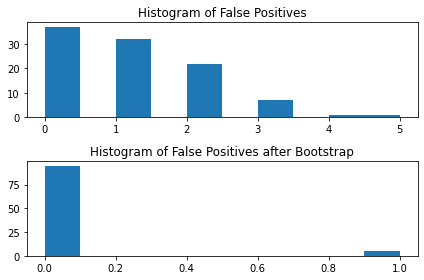

In [10]:
plt.subplot(2, 1, 1)
plt.hist(fp)
plt.title(r'Histogram of False Positives')

plt.subplot(2, 1, 2)
plt.hist(mb_fp)
plt.title(r'Histogram of False Positives after Bootstrap')

plt.tight_layout()